### For this project, we will be scraping data from GitHub repository README files. The goal will be to build a model that can predict what programming language a repository is, given the text of the README file.

#### Deliverables

1. A well-documented jupyter notebook that contains your analysis
2. Three or four google slides suitable for a general audience that summarize your findings. Include a well-labelled visualization in your slides.

In [1]:
from requests import get
from bs4 import BeautifulSoup
import os
import re
from env import github_token, github_username
import scraper
import features
import pandas as pd
import json
import seaborn as sns
import time
import prepare_r
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from wordcloud import WordCloud
import nltk
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from scipy import stats
import model
plt.rc('figure', figsize=(10, 6))
plt.rc('font', size=14)
plt.style.use('seaborn-darkgrid')

### Data Acquisition:
1. Acquire list of repos we want to analyze using the scraper.py
2. Use acquire.py (Zach's code) to scrape readme files from Github

In [2]:
# The acquired data is read from data2.json and store in a dataframe 'df'
f = open('data2.json')
json_file = json.load(f)

df = pd.DataFrame(json_file)

In [3]:
# We look at df.info() to see how many nulls we have
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             280 non-null    object
 1   language         245 non-null    object
 2   readme_contents  280 non-null    object
dtypes: object(3)
memory usage: 6.7+ KB


In [4]:
# Looks like there are 35 nulls. We can drop these
df.isnull().sum()

repo                0
language           35
readme_contents     0
dtype: int64

In [5]:
# Dropping the nulls
df = df.dropna(axis =0)

In [6]:
# Checking again to make sure no more nulls are present 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245 entries, 1 to 279
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             245 non-null    object
 1   language         245 non-null    object
 2   readme_contents  245 non-null    object
dtypes: object(3)
memory usage: 7.7+ KB


In [7]:
# Resetting index
df = df.reset_index(drop = True)

In [8]:
# Lets look at number of programming languages
df.language.value_counts()

JavaScript          58
Java                33
Python              31
C++                 16
Jupyter Notebook    12
HTML                12
Go                  11
PHP                 11
TypeScript          10
Ruby                 9
CSS                  8
C                    8
Shell                5
Vue                  3
Rust                 2
TeX                  2
PowerShell           2
Kotlin               2
C#                   2
R                    2
Groovy               1
Dart                 1
Objective-C          1
ApacheConf           1
Swift                1
Scala                1
Name: language, dtype: int64

In [9]:
# We filter out the repos with less than 5 languages
df = df.groupby('language').filter(lambda x : len(x)>5)

In [10]:
# Now we are left with repos with following languages
df.language.value_counts()

JavaScript          58
Java                33
Python              31
C++                 16
HTML                12
Jupyter Notebook    12
PHP                 11
Go                  11
TypeScript          10
Ruby                 9
C                    8
CSS                  8
Name: language, dtype: int64

In [11]:
# The function 'other' keeps only certain languages and categorized the others as "Others"
df.language = df.language.apply(prepare_r.other)

In [12]:
df.language.value_counts()

Other         69
JavaScript    58
Java          33
Python        31
C++           16
HTML          12
Name: language, dtype: int64

In [13]:
df.shape

(219, 3)

Text(0, 0.5, 'Programming Language')

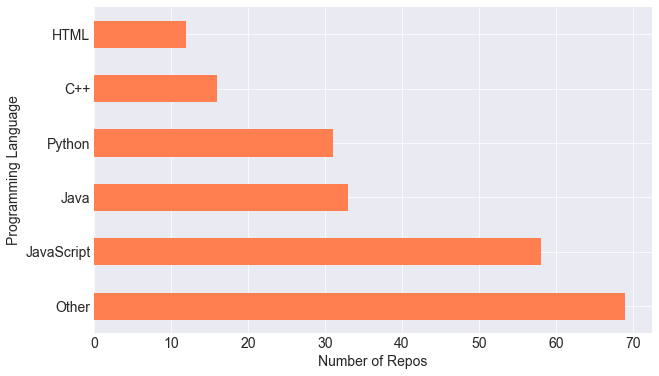

In [14]:
# bar plot showing repo counts by language
df.language.value_counts().plot.barh(color = 'coral')
plt.xlabel('Number of Repos')
plt.ylabel('Programming Language')

In [15]:
# Next we drop the column named 'repo' 
df = df.drop(columns = ['repo'])

In [16]:
# We next call a function named 'prep_contents' from prepare.py
df = prepare_r.prep_contents(df)

In [17]:
df.head(3)

,language,readme_contents,original,normalized,stemmed,lemmatized,cleaned
1,HTML,### Well hello there!\n\nThis repository is me...,### Well hello there!\n\nThis repository is me...,well hello there this repository meant pro...,well hello there thi repositori meant provid e...,well hello there this repository meant provide...,well hello repository meant provide example fo...
2,C++,"<div align=""center"">\n <img src=""https://www....","<div align=""center"">\n <img src=""https://www....",div align center img src https www te...,div align center img src http www tensorflow o...,div align center img src http www tensorflow o...,div align center img src tensorflow org image ...
4,JavaScript,"<p align=""center"">\n <a href=""https://getboot...","<p align=""center"">\n <a href=""https://getboot...",align center href https getbootstrap...,align center href http getbootstrap com img sr...,align center href http getbootstrap com img sr...,align center href getbootstrap com img src get...


In [18]:
# We will just work with either original content or 'cleaned' column. So we drop other columns
df = df.drop(columns = ['original', 'stemmed', 'normalized', 'lemmatized'])
df = df.reset_index()
df.head(4)

,index,language,readme_contents,cleaned
0,1,HTML,### Well hello there!\n\nThis repository is me...,well hello repository meant provide example fo...
1,2,C++,"<div align=""center"">\n <img src=""https://www....",div align center img src tensorflow org image ...
2,4,JavaScript,"<p align=""center"">\n <a href=""https://getboot...",align center href getbootstrap com img src get...
3,5,Python,![Logo](https://storage.googleapis.com/model_g...,logo storage googleapis com model garden artif...


In [33]:
# Train/test split before exploration
train, test = train_test_split(df, stratify=df.language, test_size=.2, random_state=123)

## Exploration: We will do exploration on train dataset
***

In [34]:
# Which words appear most often in the corpus?
word_counts = pd.Series(" ".join(train.cleaned).split()).value_counts().head(15)
word_counts

com        9172
org        1773
img        1149
doc        1116
python     1088
master     1000
svg         988
code        952
api         941
src         917
use         882
file        877
html        857
library     851
data        821
dtype: int64

Text(0.5, 1.0, '15 most common words in GitHub Readme.md')

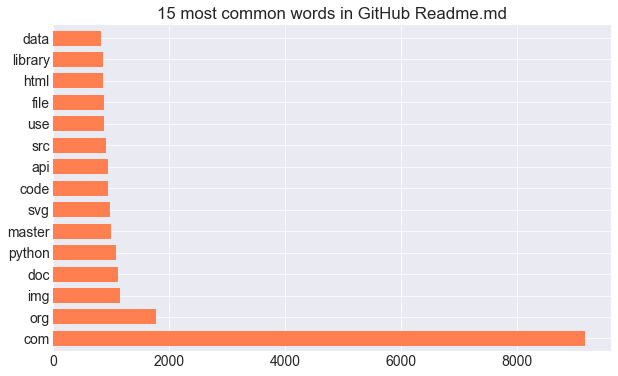

In [35]:
word_counts.plot.barh(width=0.7, color = 'coral')
plt.title('15 most common words in GitHub Readme.md')

In [36]:
#IDF function
def idf(word):
    n_occurences = sum([1 for doc in train.cleaned if word in doc])
    return len(train.cleaned) / n_occurences

In [37]:
#Find unique word list from DF cleaned column
unique_words = pd.Series(' '.join(train.cleaned).split()).unique()
unique_words

array(['python', 'server', 'com', ..., 'happyholidaysto',
       'happycustomholidayto', 'holidaycountdown'], dtype=object)

In [38]:
# make a data frame for unique words
idf_train = pd.DataFrame(dict(word = unique_words))\
.assign(idf = lambda train: train.word.apply(idf))\
.set_index('word').sort_values(by='idf', ascending = False)

In [39]:
idf_train.head(10)

,idf
word,
holidaycountdown,175.0
myapps,175.0
gurkankaymak,175.0
launching,175.0
ahoy,175.0
wordmark,175.0
hocon,175.0
hjson,175.0
intuitcom,175.0


Text(0.5, 0, 'IDF value')

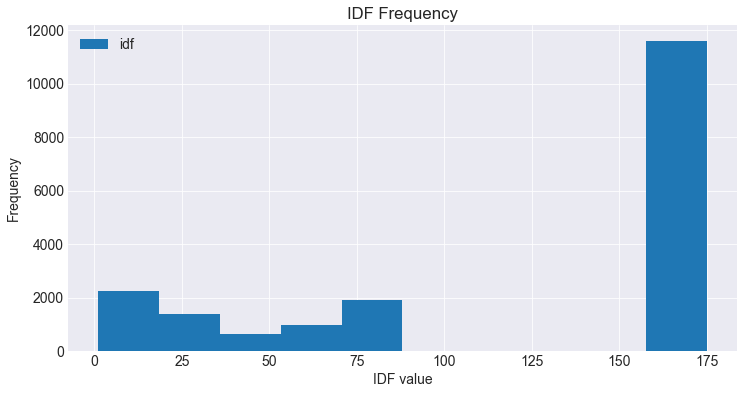

In [40]:
idf_train.plot.hist(figsize=(12,6))
plt.title('IDF Frequency')
plt.xlabel('IDF value')

In [41]:
# Next we create a new column with number of words for each readme file.
train['readme_words'] = train['cleaned'].apply(lambda x: len(x.split()))

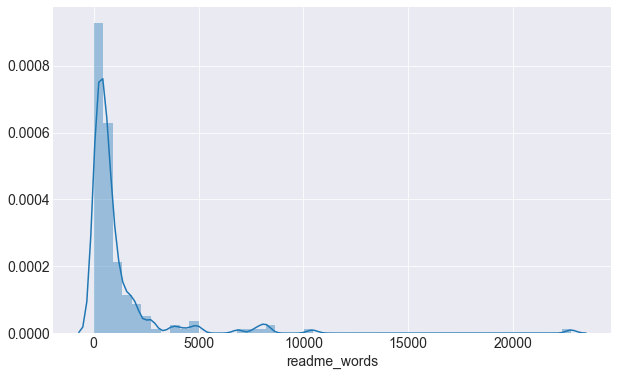

In [42]:
# Plot the distribution of number of words in readme files
sns.distplot(train.readme_words)

The distribution is normal but right skewed

Text(0.5, 1.0, 'Word Count')

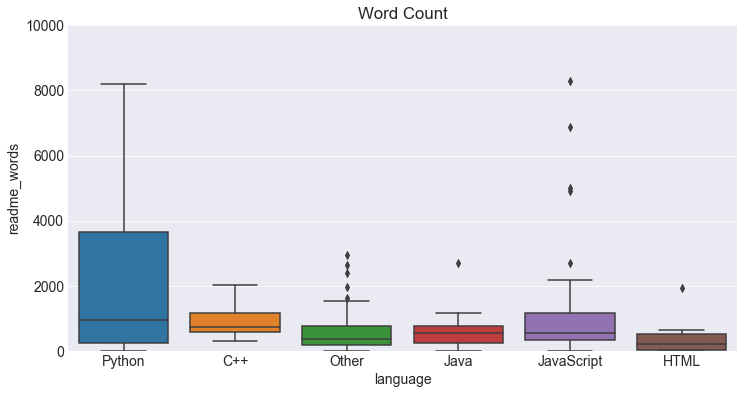

In [75]:
# BoxPlot of number of word by language
plt.figure(figsize = (12,6))
sns.boxplot(x = 'language', y = 'readme_words', data = train)
plt.ylim(0,10000)
plt.title ('Word Count')

(0, 5000)

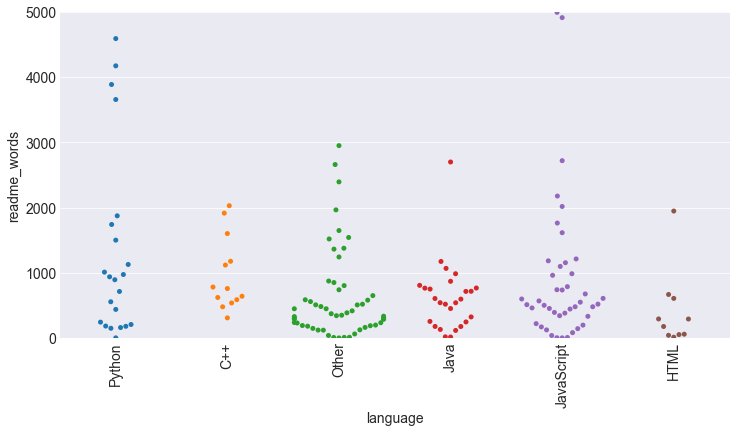

In [44]:
# SwarmPlot of number of word by language
plt.figure(figsize = (12,6))
sns.swarmplot(x = 'language', y = 'readme_words', data = train)
plt.xticks(rotation = 90)
plt.ylim(0,5000)

#### It seems like the median length of readme file is not very different between languages. Python however seems to have much bigger spread. We can do statistical testing:

#### T- test to see if mean of number of words for Python and Javascript is any different:

$H_0$: The mean number of words between Python and Javascript is same.\
$H_a$: The mean number of words between Python and Javascript is different.

In [45]:
# T-test 
x1 = train[train.language == 'Python'].readme_words
x2 = train[train.language == 'JavaScript'].readme_words
stats.ttest_ind(x1, x2)

Ttest_indResult(statistic=1.2609780430855242, pvalue=0.21156378450034752)

#### Since p >0.05 we fail to reject the null hypothesis
***

#### T- test to see if mean of number of words for Other and Javascript is any different:

$H_0$: The mean number of words between Other and Javascript is same.\
$H_a$: The mean number of words between Other and Javascript is different.

In [46]:
x1 = train[train.language == 'Other'].readme_words
x2 = train[train.language == 'JavaScript'].readme_words
stats.ttest_ind(x1, x2)

Ttest_indResult(statistic=-0.6771665607182691, pvalue=0.49987960999356507)

#### Since p >0.05 we fail to reject the null hypothesis
****

In [47]:
# We will explore all the words that appear in cleaned readme column
All_words = pd.Series(' '.join(train.cleaned).split()).value_counts()
JavaScript_words = pd.Series(' '.join(train[train.language == 'JavaScript'].cleaned).split()).value_counts()
Other_words = pd.Series(' '.join(train[train.language == 'Other'].cleaned).split()).value_counts()
Python_words = pd.Series(' '.join(train[train.language == 'Python'].cleaned).split()).value_counts()
java_words = pd.Series(' '.join(train[train.language == 'Java'].cleaned).split()).value_counts()
Cplus_words = pd.Series(' '.join(train[train.language == 'C++'].cleaned).split()).value_counts()
HTML_words = pd.Series(' '.join(train[train.language == 'HTML'].cleaned).split()).value_counts()


In [48]:
# Making a dataframe and sort values by "All column"
word_counts = (pd.concat([All_words, JavaScript_words, Other_words, Python_words,java_words, Cplus_words,\
                         HTML_words],\
                         axis=1, sort=True).set_axis(['All','JavaScript', 'Other', 'Python','Java', 'C++',\
                         'HTML'], axis=1, inplace=False).fillna(0)\
               .apply(lambda s: s.astype(int)))

word_counts.sort_values(by='All', ascending=False).head(15)

,All,JavaScript,Other,Python,Java,C++,HTML
com,9172,2093,3264,2627,582,480,126
org,1773,492,350,493,131,280,27
img,1149,681,157,136,127,39,9
doc,1116,307,173,297,231,95,13
python,1088,2,236,787,5,57,1
master,1000,185,387,198,90,134,6
svg,988,615,168,66,71,64,4
code,952,205,393,244,42,47,21
api,941,207,225,419,49,40,1
src,917,679,77,72,57,28,4


In [49]:
#Words counts sorted by JavaScript
word_counts.sort_values(by='JavaScript', ascending=False).head(15)

,All,JavaScript,Other,Python,Java,C++,HTML
com,9172,2093,3264,2627,582,480,126
opencollective,768,713,14,1,14,26,0
webpack,733,713,20,0,0,0,0
img,1149,681,157,136,127,39,9
src,917,679,77,72,57,28,4
false,671,647,9,11,1,0,3
svg,988,615,168,66,71,64,4
javascript,718,613,26,8,2,9,60
href,749,534,69,89,38,14,5
requireactive,524,524,0,0,0,0,0


In [50]:
word_counts.sort_values(by='Python', ascending=False).head(15)

,All,JavaScript,Other,Python,Java,C++,HTML
com,9172,2093,3264,2627,582,480,126
python,1088,2,236,787,5,57,1
yes,670,7,2,661,0,0,0
unknown,565,0,4,561,0,0,0
org,1773,492,350,493,131,280,27
api,941,207,225,419,49,40,1
model,470,8,54,398,2,8,0
data,821,202,177,372,52,14,4
youtube,404,16,10,367,5,6,0
video,390,15,52,313,1,0,9


### We see certain words which are very JavaScript specific e.g. 'opencollective', 'webpack'  or very Python Specific e.g. 'yes', 'youtube', 'unknown' etc. We can do a word cloud here

Text(0.5, 1.0, 'Word cloud for all words')

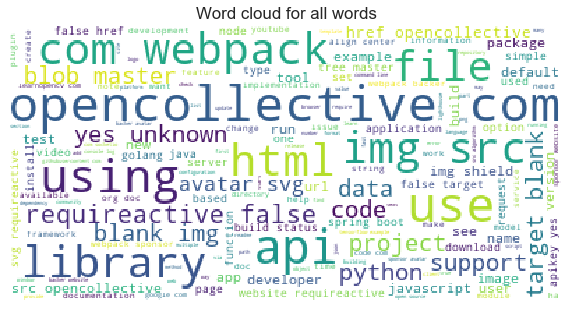

In [51]:
# word cloud for all words
img = WordCloud(background_color='white').generate(' '.join(train.cleaned))
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.title('Word cloud for all words')

Text(0.5, 1.0, 'Python wordcloud')

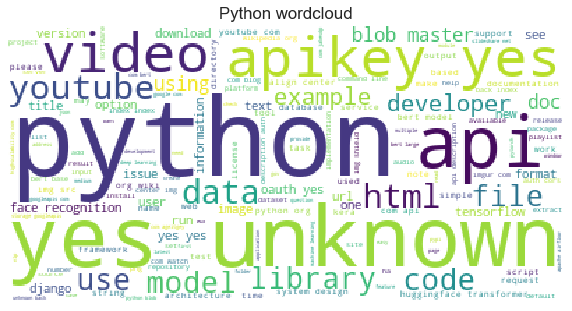

In [52]:
# word cloud for Python
img = WordCloud(background_color='white').generate(' '.join(train[train.language == 'Python'].cleaned))
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.title('Python wordcloud')

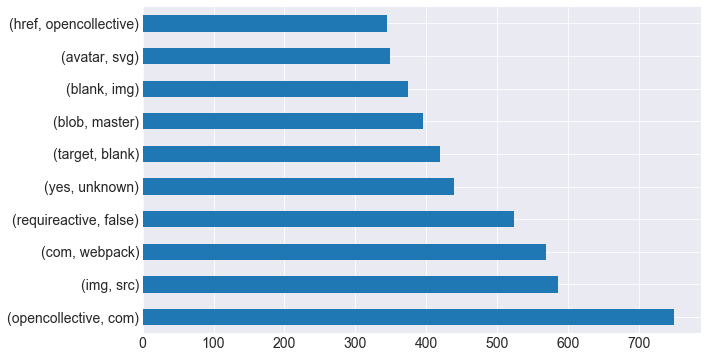

In [76]:
#lets look at bigrams for all text
bigrams = nltk.ngrams(' '.join(train.cleaned).split(), 2)
pd.Series(bigrams).value_counts().head(10).plot.barh()

In [77]:
top_30_bigrams = pd.Series(nltk.ngrams(' '.join(train.cleaned).split(), 2)).value_counts().head(30)

Text(0.5, 1.0, 'Top 30 Bigrams')

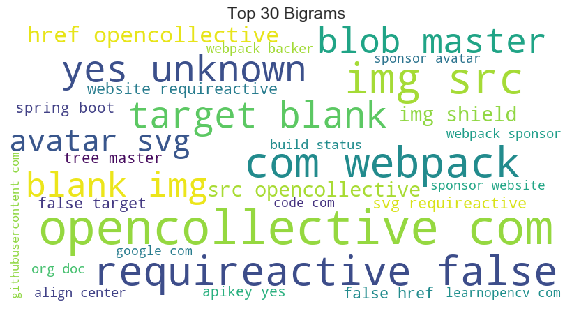

In [78]:
data = {k[0] + ' ' + k[1]: v for k, v in top_30_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.title('Top 30 Bigrams')

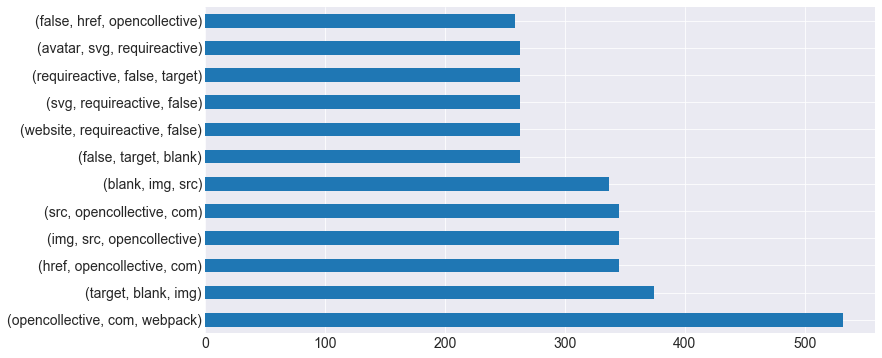

In [79]:
#lets look at trigrams for all text
plt.figure(figsize = (12,6))
trigrams = nltk.ngrams(' '.join(train.cleaned).split(), 3)
pd.Series(trigrams).value_counts().head(12).plot.barh()

In [80]:
top_30_trigrams = pd.Series(nltk.ngrams(' '.join(train.cleaned).split(), 3)).value_counts().head(30)

Text(0.5, 1.0, 'Top 30 Trigrams')

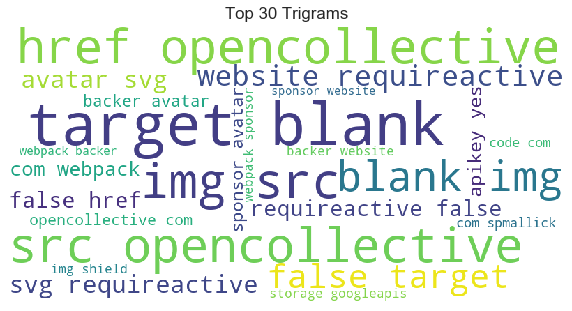

In [81]:
data = {k[0] + ' ' + k[1]: v for k, v in top_30_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.title('Top 30 Trigrams')

In [59]:
# Next we create new features e.g. 'word count', 'sentence count', ''# of headings', 'number of digits', 'no of links'
train = features.add_features(train)

In [60]:
train.tail(3)

,index,language,readme_contents,cleaned,readme_words,word_count,sentence_count,bracket_count,angle_bracket_count,headings1,headings2,headings3,headings4,headings,link,digits,total
111,130,JavaScript,"node-echo\n=========\n\nnode.js echo server, r...",node echo node echo server return request data...,9,9,2,0,0,0,0,0,0,0,0,0,9
54,62,JavaScript,# Atom\n\n[![Build status](https://dev.azure.c...,atom build status dev azure com atom apis buil...,445,445,36,30,0,4,5,4,1,14,29,125,488
217,243,JavaScript,# JavaScript Functions\n\n## Objectives\n\n1. ...,javascript function objective write function r...,343,343,27,1,4,0,4,0,0,4,2,20,349


Text(0.5, 1.0, 'Sentence Count')

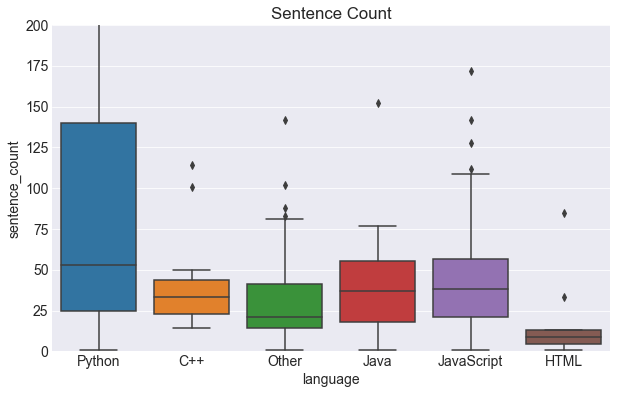

In [61]:
sns.boxplot(x = 'language', y = 'sentence_count', data = train)
plt.ylim(0,200)
plt.title('Sentence Count')

#### We will run a one way ANOVA test to see if the mean of these groups are different.

$H_0$: The mean number of groups is same.\
$H_a$: The mean number of group is different.



In [62]:
# One way F test (ANOVA from scipy)

python_s = train[train.language == "Python"].sentence_count
C_plus_s = train[train.language == "C++"].sentence_count
Other_s = train[train.language == "Other"].sentence_count
Java_s = train[train.language == "Java"].sentence_count
JS_s = train[train.language == "JavaScript"].sentence_count
HTML_s = train[train.language == "HTML"].sentence_count



stats.f_oneway(python_s, C_plus_s, Other_s, Java_s, HTML_s)

F_onewayResult(statistic=4.5989972645127795, pvalue=0.0016982227043776808)

#### The p value is less than 0.05. This means we can reject the null hypothesis. This could be a useful feature for modeling
***

Text(0.5, 1.0, 'Cound of Markdown Headings')

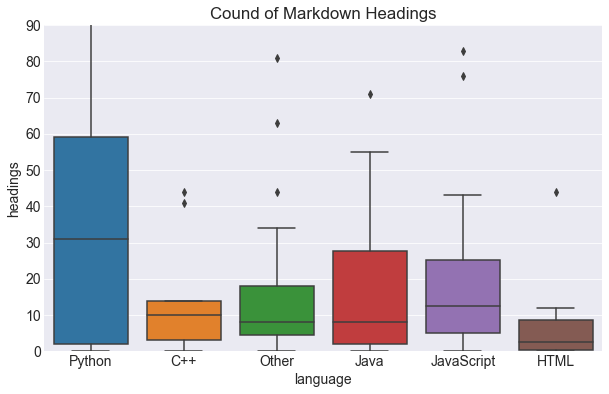

In [70]:
# Boxplot of language vs word count
sns.boxplot(x = 'language', y = 'headings', data = train)
plt.ylim(0,90)
plt.title('Cound of Markdown Headings')

#### We will run a one way ANOVA test to see if the mean of these groups are different.

$H_0$: The mean number of groups is same.\
$H_a$: The mean number of group is different.



In [64]:
# Anova test to determine if means of the groups below are different

python_h = train[train.language == "Python"].headings
C_plus_h = train[train.language == "C++"].headings
Other_h = train[train.language == "Other"].headings
Java_h = train[train.language == "Java"].headings
JS_h = train[train.language == "JavaScript"].headings
HTML_h = train[train.language == "HTML"].headings
stats.f_oneway(python_s, C_plus_s, Other_s, Java_s, HTML_s)

F_onewayResult(statistic=4.5989972645127795, pvalue=0.0016982227043776808)

#### The p value is < 0.05, so we can reject the null hypothesis and use no of headings as a feature
***

(0, 1000)

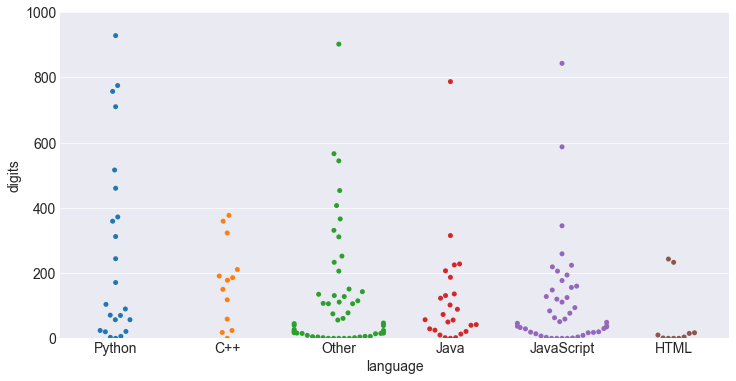

In [65]:
# Swarm plot for number of digits in readme file
plt.figure(figsize = (12,6))
sns.swarmplot(x = 'language', y = 'digits', data = train)
plt.ylim(0,1000)

Text(0.5, 1.0, 'Number of URL links')

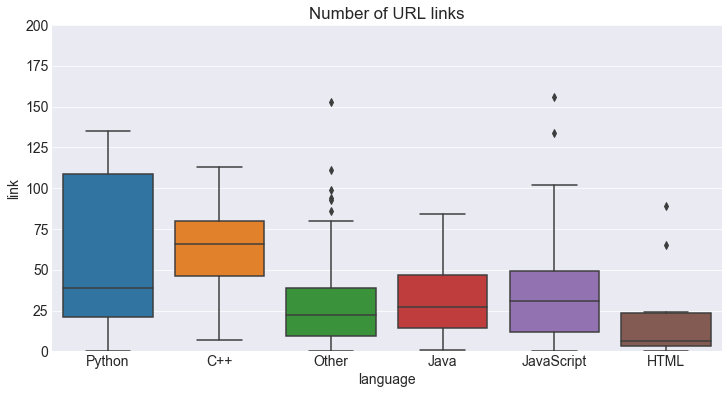

In [74]:
plt.figure(figsize = (12,6))
sns.boxplot(x = 'language', y = 'link', data = train)
plt.ylim(0,200)
plt.title('Number of URL links')

In [67]:
# Next we can calculate number of stopwords in each readme file
from nltk.corpus import stopwords
stop = stopwords.words('english')
train['stopwords'] = train['readme_contents'].apply(lambda x: len([x for x in x.split() if x in stop]))

(0, 1000)

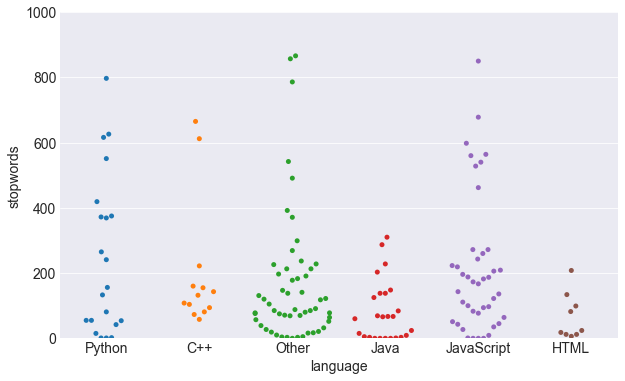

In [68]:
#swarm plot of number of stopwords for each language
sns.swarmplot(x = 'language', y = 'stopwords', data = train)
plt.ylim(0,1000)

## Modeling - Baseline

In [106]:
# For Baseline we can predict most frequent languages in the corpus i.e. Javascript
Baseline_accuracy = 58/219
print('Baseline Accuracy: {:.1%}'.format(Baseline_accuracy))

Baseline Accuracy: 26.5%


## Modeling Using Bag of Words

In [54]:
cv = CountVectorizer(ngram_range=(2, 2))
X = cv.fit_transform(df.cleaned)
y = df.language

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state = 123)

In [56]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=123)
clf.fit(X_train, y_train)
train['predicted'] = clf.predict(X_train)
test['predicted'] = clf.predict(X_test)

In [57]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 54.29%
---
Confusion Matrix
actual      C++  HTML  Java  JavaScript  Other  Python
predicted                                             
C++           8     0     0           0      0       1
Java          0     0    12           0      3       3
JavaScript    1     0     0          23      0       0
Other         4    10    14          23     52      21
---
              precision    recall  f1-score   support

         C++       0.89      0.62      0.73        13
        HTML       0.00      0.00      0.00        10
        Java       0.67      0.46      0.55        26
  JavaScript       0.96      0.50      0.66        46
       Other       0.42      0.95      0.58        55
      Python       0.00      0.00      0.00        25

    accuracy                           0.54       175
   macro avg       0.49      0.42      0.42       175
weighted avg       0.55      0.54      0.49       175



In [58]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 40.91%
---
Confusion Matrix
actual      C++  HTML  Java  JavaScript  Other  Python
predicted                                             
C++           0     0     0           0      1       0
Java          0     0     2           1      0       1
JavaScript    1     0     0           3      0       0
Other         2     2     5           8     13       5
---
              precision    recall  f1-score   support

         C++       0.00      0.00      0.00         3
        HTML       0.00      0.00      0.00         2
        Java       0.50      0.29      0.36         7
  JavaScript       0.75      0.25      0.38        12
       Other       0.37      0.93      0.53        14
      Python       0.00      0.00      0.00         6

    accuracy                           0.41        44
   macro avg       0.27      0.24      0.21        44
weighted avg       0.40      0.41      0.33        44



## Modeling

#### The modeling functions are in model.py file

#### Logistic Regression Model

In [59]:
#First we run the Logistic Regression model on train dataset
model.logistic_reg(df,'train', 100)

Accuracy: 100.00%
---
Confusion Matrix
actual      C++  HTML  Java  JavaScript  Other  Python
predicted                                             
C++          13     0     0           0      0       0
HTML          0    10     0           0      0       0
Java          0     0    26           0      0       0
JavaScript    0     0     0          46      0       0
Other         0     0     0           0     55       0
Python        0     0     0           0      0      25
---
              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        13
        HTML       1.00      1.00      1.00        10
        Java       1.00      1.00      1.00        26
  JavaScript       1.00      1.00      1.00        46
       Other       1.00      1.00      1.00        55
      Python       1.00      1.00      1.00        25

    accuracy                           1.00       175
   macro avg       1.00      1.00      1.00       175
weighted avg       1.00      

In [60]:
#Logistic Regression model for test dataset
model.logistic_reg(df,'test', 10)

Accuracy: 61.36%
---
Confusion Matrix
actual      C++  HTML  Java  JavaScript  Other  Python
predicted                                             
Java          0     0     4           0      1       0
JavaScript    0     1     1           8      1       1
Other         3     1     2           4     12       2
Python        0     0     0           0      0       3
---
              precision    recall  f1-score   support

         C++       0.00      0.00      0.00         3
        HTML       0.00      0.00      0.00         2
        Java       0.80      0.57      0.67         7
  JavaScript       0.67      0.67      0.67        12
       Other       0.50      0.86      0.63        14
      Python       1.00      0.50      0.67         6

    accuracy                           0.61        44
   macro avg       0.49      0.43      0.44        44
weighted avg       0.60      0.61      0.58        44



#### Decision Tree Classifier

In [61]:
model.DecisionTree_clf(df, 'train')

Accuracy: 67.43%
---
Confusion Matrix
actual      C++  HTML  Java  JavaScript  Other  Python
predicted                                             
C++           8     0     0           0      0       0
Java          0     2    16           0      0       0
JavaScript    1     0     0          32      5       0
Other         4     8    10          14     42       5
Python        0     0     0           0      8      20
---
              precision    recall  f1-score   support

         C++       1.00      0.62      0.76        13
        HTML       0.00      0.00      0.00        10
        Java       0.89      0.62      0.73        26
  JavaScript       0.84      0.70      0.76        46
       Other       0.51      0.76      0.61        55
      Python       0.71      0.80      0.75        25

    accuracy                           0.67       175
   macro avg       0.66      0.58      0.60       175
weighted avg       0.69      0.67      0.66       175



In [62]:
model.DecisionTree_clf(df, 'test')

Accuracy: 56.82%
---
Confusion Matrix
actual      C++  HTML  Java  JavaScript  Other  Python
predicted                                             
Java          1     0     4           0      0       1
JavaScript    0     0     0           5      0       0
Other         2     2     3           6     13       2
Python        0     0     0           1      1       3
---
              precision    recall  f1-score   support

         C++       0.00      0.00      0.00         3
        HTML       0.00      0.00      0.00         2
        Java       0.67      0.57      0.62         7
  JavaScript       1.00      0.42      0.59        12
       Other       0.46      0.93      0.62        14
      Python       0.60      0.50      0.55         6

    accuracy                           0.57        44
   macro avg       0.46      0.40      0.39        44
weighted avg       0.61      0.57      0.53        44



#### KNN model

In [63]:
# Run KNN model on train data
model.KNN_clf(df,'train', 6)

Accuracy: 63.43%
---
Confusion Matrix
actual      C++  HTML  Java  JavaScript  Other  Python
predicted                                             
C++           4     0     1           1      1       0
HTML          0     0     0           1      0       0
Java          0     1    21           2      0       1
JavaScript    2     4     2          36     16       2
Other         1     5     0           3     32       4
Python        6     0     2           3      6      18
---
              precision    recall  f1-score   support

         C++       0.57      0.31      0.40        13
        HTML       0.00      0.00      0.00        10
        Java       0.84      0.81      0.82        26
  JavaScript       0.58      0.78      0.67        46
       Other       0.71      0.58      0.64        55
      Python       0.51      0.72      0.60        25

    accuracy                           0.63       175
   macro avg       0.54      0.53      0.52       175
weighted avg       0.62      0

In [64]:
# Run KNN model on test data
model.KNN_clf(df,'test', 6)

Accuracy: 54.55%
---
Confusion Matrix
actual      C++  HTML  Java  JavaScript  Other  Python
predicted                                             
HTML          0     1     1           0      0       0
Java          0     0     6           0      1       0
JavaScript    0     0     0           8      2       1
Other         1     0     0           1      5       1
Python        2     1     0           3      6       4
---
              precision    recall  f1-score   support

         C++       0.00      0.00      0.00         3
        HTML       0.50      0.50      0.50         2
        Java       0.86      0.86      0.86         7
  JavaScript       0.73      0.67      0.70        12
       Other       0.62      0.36      0.45        14
      Python       0.25      0.67      0.36         6

    accuracy                           0.55        44
   macro avg       0.49      0.51      0.48        44
weighted avg       0.59      0.55      0.54        44



#### Random Forest Classifier

In [65]:
# Run Random Forest Classifier on train dataset
model.RF_clf(df, 'train')

Accuracy: 67.43%
---
Confusion Matrix
actual      C++  HTML  Java  JavaScript  Other  Python
predicted                                             
C++           8     0     0           0      0       0
Java          0     2    16           0      0       0
JavaScript    1     0     0          32      5       0
Other         4     8    10          14     42       5
Python        0     0     0           0      8      20
---
              precision    recall  f1-score   support

         C++       1.00      0.62      0.76        13
        HTML       0.00      0.00      0.00        10
        Java       0.89      0.62      0.73        26
  JavaScript       0.84      0.70      0.76        46
       Other       0.51      0.76      0.61        55
      Python       0.71      0.80      0.75        25

    accuracy                           0.67       175
   macro avg       0.66      0.58      0.60       175
weighted avg       0.69      0.67      0.66       175



In [66]:
# Run Random Forest Classifier on test dataset
model.RF_clf(df, 'test')

Accuracy: 56.82%
---
Confusion Matrix
actual      C++  HTML  Java  JavaScript  Other  Python
predicted                                             
Java          1     0     4           0      0       1
JavaScript    0     0     0           5      0       0
Other         2     2     3           6     13       2
Python        0     0     0           1      1       3
---
              precision    recall  f1-score   support

         C++       0.00      0.00      0.00         3
        HTML       0.00      0.00      0.00         2
        Java       0.67      0.57      0.62         7
  JavaScript       1.00      0.42      0.59        12
       Other       0.46      0.93      0.62        14
      Python       0.60      0.50      0.55         6

    accuracy                           0.57        44
   macro avg       0.46      0.40      0.39        44
weighted avg       0.61      0.57      0.53        44



### Naive Bayes Multinomial Classifier

In [67]:
# Run Naive Bayes Classifier on train data
model.NB_Multinomial(df, 'train', 0.01)

Accuracy of Naive Bayes classifier on training set: 1.00
              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        13
        HTML       1.00      1.00      1.00        10
        Java       1.00      1.00      1.00        26
  JavaScript       1.00      1.00      1.00        46
       Other       1.00      1.00      1.00        55
      Python       1.00      1.00      1.00        25

    accuracy                           1.00       175
   macro avg       1.00      1.00      1.00       175
weighted avg       1.00      1.00      1.00       175



In [68]:
# Run Naive Bayes Classifier on test data
model.NB_Multinomial(df, 'test', 0.01)

Accuracy of Naive Bayes classifier on test set: 0.68
              precision    recall  f1-score   support

         C++       0.00      0.00      0.00         3
        HTML       1.00      0.50      0.67         2
        Java       0.83      0.71      0.77         7
  JavaScript       0.67      0.83      0.74        12
       Other       0.67      0.71      0.69        14
      Python       0.67      0.67      0.67         6

    accuracy                           0.68        44
   macro avg       0.64      0.57      0.59        44
weighted avg       0.66      0.68      0.67        44



### Add Addtional Features

In [83]:
#add all the features created to df
df = features.add_features(df)
df.head(2)

,index,language,readme_contents,cleaned,word_count,sentence_count,bracket_count,angle_bracket_count,headings1,headings2,headings3,headings4,headings,link,digits,total
0,1,HTML,### Well hello there!\n\nThis repository is me...,well hello repository meant provide example fo...,68,5,2,0,0,0,0,0,0,2,0,70
1,2,C++,"<div align=""center"">\n <img src=""https://www....",div align center img src tensorflow org image ...,1177,34,116,4,2,5,2,1,10,113,186,1300


In [88]:
# Here are different features identified during exploration
word_count          = df[['word_count']]
sentence_count      = df[['sentence_count']]
bracket_count       = df[['bracket_count']]
angle_bracket_count = df[['angle_bracket_count']]
headings           = df[['headings']]
link           =   df[['link']]
total           =   df[['total']]

features = pd.concat([word_count, sentence_count, bracket_count, angle_bracket_count, headings, link, total], axis=1)

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.cleaned)
y = df.language

In [91]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(features))

In [94]:
X  = pd.DataFrame(X.todense(), columns=tfidf.get_feature_names())
X = pd.concat([X, features_scaled], axis=1)

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state = 123)

In [96]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

In [98]:
# Run Naive Bayes Classifier on train data
clf = MultinomialNB(alpha = 0.01)
clf.fit(X_train, y_train)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [99]:
y_pred = clf.predict(X_train)
print('Accuracy of Naive Bayes classifier on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print(classification_report(y_train, y_pred))

Accuracy of Naive Bayes classifier on training set: 1.00
              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        13
        HTML       1.00      1.00      1.00        10
        Java       1.00      1.00      1.00        26
  JavaScript       1.00      1.00      1.00        46
       Other       1.00      1.00      1.00        55
      Python       1.00      1.00      1.00        25

    accuracy                           1.00       175
   macro avg       1.00      1.00      1.00       175
weighted avg       1.00      1.00      1.00       175



In [100]:
y_pred = clf.predict(X_test)
print('Accuracy of Naive Bayes classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))
print(classification_report(y_test, y_pred))


Accuracy of Naive Bayes classifier on test set: 0.68
              precision    recall  f1-score   support

         C++       0.00      0.00      0.00         3
        HTML       1.00      0.50      0.67         2
        Java       0.83      0.71      0.77         7
  JavaScript       0.67      0.83      0.74        12
       Other       0.67      0.71      0.69        14
      Python       0.67      0.67      0.67         6

    accuracy                           0.68        44
   macro avg       0.64      0.57      0.59        44
weighted avg       0.66      0.68      0.67        44



#### Takeaway: Addition of new features does not improve the accuracy of model